# Programming Exercise 4: Neural Networks Learning

In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

## 1. Neural Networks

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

### 1.1. Visualizing the data

This is the same dataset that you used in the previous exercise. There are 5000 training examples in `ex34data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.

In [1]:
# Import function to load .mat files
from scipy.io import loadmat

In [2]:
# Load data
data = loadmat('ex4data1.mat')
X = data['X']
y = data['y']
y = y.T[0]
y[y == 10] = 0

In [3]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
# Select some random training data points
n = 50
X_vis = X[np.random.randint(X.shape[0], size=n)]

In [5]:
def display_numbers(X_vis):
    # Compute rows, cols
    if X_vis.ndim == 1:
        m, n = 1, len(X_vis)
    else:
        m, n = X_vis.shape
    example_width = np.round(np.sqrt(n)).astype(int)
    example_height = (n / example_width).astype(int)
    
    # Compute number of items to display
    display_rows = np.floor(np.sqrt(m)).astype(int)
    display_cols = np.ceil(m / display_rows).astype(int)
    
    # Between images padding
    pad = 1
    # Setup blank display
    display_array = - np.ones((pad + display_rows * (example_height + pad),
                               pad + display_cols * (example_width + pad)))
    
    # Copy each example into a patch on the display array
    if m == 1:
        max_val = np.max(np.abs(X_vis))
        display_array = np.reshape(X_vis, (example_height, example_width)) / max_val
    else:
        curr_ex = 0;
        for j in range(display_rows):
            for i in range(display_cols):
                if curr_ex >= m:
                    break
                # Copy the patch

                # Get the max value of the patch
                max_val = np.max(np.abs(X_vis[curr_ex, :]))
                rows = pad + j * (example_height + pad) + np.arange(example_height)
                cols = pad + i * (example_width + pad) + np.arange(example_width)
                display_array[np.ix_(rows, cols)] = np.reshape(X_vis[curr_ex, :], (example_height, example_width)) / max_val
                curr_ex = curr_ex + 1

            if curr_ex >= m:
                break
    
    # Display image
    plt.imshow(display_array.T)
    plt.show()

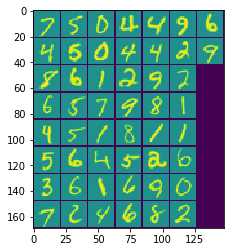

In [6]:
display_numbers(X_vis)

### 1.3. Feedforward and cost function

Now you will implement the cost function and gradient for the neural network.

In [7]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [8]:
# Forward propagation (3 layer NN)
def forward_propagation(Theta_vec, s1, s2, s3, X, y):
    # Number of examples
    m = X.shape[0]
    
    # Reshape parameters
    Theta1 = Theta_vec[:s2 * (s1 + 1)].reshape(s2, s1 + 1, order='F')
    Theta2 = Theta_vec[s2 * (s1 + 1):].reshape(s3, s2 + 1, order='F')
    
    # Input Layer
    A1 = X.T
    # Hidden Layer
    Z2 = Theta1.dot(np.block([[np.ones((1, m))],
                              [A1]            ]))
    A2 = sigmoid(Z2)
    # Output Layer
    Z3 = Theta2.dot(np.block([[np.ones((1, m))],
                              [A2]            ]))
    A3 = sigmoid(Z3)
    
    return A1, A2, A3, Theta1, Theta2

In [18]:
# Cost function
def J_NN(Theta_vec, s1, s2, s3, X, y, l):
    # Number of examples
    m = X.shape[0]
    
    # Forward propagation
    _, _, A3, Theta1, Theta2 = forward_propagation(Theta_vec, s1, s2, s3, X, y)
    
    # Identity s3
    I_s3 = np.eye(s3)
    # Output matrix
    Y = np.concatenate([np.array([I_s3[:, ele]]).T for ele in y], axis=1)
    
    # Cost function
    J = -(Y * np.log(A3) + (1 - Y) * np.log(1 - A3)).sum() / m + l * ((Theta1[:, 1:]**2).sum() + (Theta2**2).sum()) / (2 * m)
    print(J)
    
    return J

## 2. Backpropagation

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function.

In [10]:
# Back propagation
def back_propagation(Theta_vec, s1, s2, s3, X, y, l):
    # Number of training examples
    m = X.shape[0]
    
    # Forward propagation
    A1, A2, A3, Theta1, Theta2 = forward_propagation(Theta_vec, s1, s2, s3, X, y)
    
    # Identity s3
    I_s3 = np.eye(s3)
    
    # Initialization of D
    D1 = np.zeros((s2, 1 + s1))
    D2 = np.zeros((s3, 1 + s2))
    for t in range(m):
        # Input units
        a1 = A1[:, t]
        # Hidden units
        a2 = A2[:, t]
        # Output units
        a3 = A3[:, t]
        # Output
        yt = I_s3[:, y[t]]
        
        # Output layer error
        delta3 = a3 - yt
        # Hidden layer error
        delta2 = (Theta2[:, 1:].T.dot(delta3)) * a2 * (1 - a2)
        
        # Gradient updates
        D1 += np.array([delta2]).T.dot(np.array([np.block([1, a1.T])]))
        D2 += np.array([delta3]).T.dot(np.array([np.block([1, a2.T])]))
    
    # Add regularization gradients
    D1 = (D1 + l * np.block([np.zeros((s2, 1)), np.ones((s2, s1))]) * Theta1) / m
    D2 = (D2 + l * np.block([np.zeros((s3, 1)), np.ones((s3, s2))]) * Theta2) / m
    
    # Unroll gradients
    Dvec = np.block([D1.reshape(np.prod(D1.shape), order='F'), D2.reshape(np.prod(D2.shape), order='F')])
    
    return Dvec

### 2.1. Random initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[−\epsilon , \epsilon]$.

In [11]:
# Random initialization
def rand_init(L_in, L_out):
    epsilon = np.sqrt(6) / (np.sqrt(L_in + L_out))
    return np.random.rand(L_out, 1 + L_in) * 2 * epsilon - epsilon

In [12]:
# Layer sizes
s1 = X.shape[1]
s2 = 25
s3 = 10

In [13]:
# Initialize Theta
Theta1_ini = rand_init(s1, s2)
Theta2_ini = rand_init(s2, s3)

In [14]:
# Unroll
Theta_vec_ini = np.block([Theta1_ini.reshape(np.prod(Theta1_ini.shape), order='F'),
                          Theta2_ini.reshape(np.prod(Theta2_ini.shape), order='F')])

### 2.2. Parameter learning

In [20]:
# Numerical optimizer
from scipy.optimize import minimize, fmin_cg

In [22]:
# Learn
solution = fmin_cg(f=J_NN,
                   x0=Theta_vec_ini,
                   args=(s1, s2, s3, X, y, 1),
                   fprime=back_propagation,
                   maxiter=50)

7.4809549357913045
4.520870366248704
3.4071266949766343
3.194239965491314
3.1454882048359694
2.981505783221416
2.790503925028577
2.473933513088133
2.309309236659042
2.171756164772508
2.075031256726733
1.8420177362586483
1.7162923213536427
1.66903409612829
1.5771219930122693
1.529992453460693
1.4383873334088826
1.384938731244174
1.2796550022750102
1.2514098103166325
1.1745730726442223
1.1475749945264444
1.112684361819852
1.0830861463983266
1.0600445904918876
1.013296361998148
0.9971607035908431
0.9657212294736046
0.9513949868310488
0.9127688427537675
0.9049610744045501
0.8871723683431888
0.8813878371876532
0.8630865770581153
0.8496434812775597
0.8372350161467735
0.8081241779796391
0.794535037987401
0.7687423245119982
0.7626435235941078
0.7504749181025446
0.7471987796356319
0.7375551591889856
0.7331612601609485
0.7270999930252638
0.7089047597649161
0.6993437442826658
0.6935598846365945
0.680017535518779
0.6758820102781529
0.6626632344303298
0.6525151512381573
0.6462947333943458
0.6383215

In [23]:
solution

array([ 0.66481871,  0.63495773,  0.29419428, ...,  1.26459773,
        1.57291171, -1.09798127])

In [25]:
# Reshape parameters
Theta_vec = solution
Theta1 = Theta_vec[:s2 * (s1 + 1)].reshape(s2, s1 + 1, order='F')
Theta2 = Theta_vec[s2 * (s1 + 1):].reshape(s3, s2 + 1, order='F')

In [29]:
# Predictions
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    # a1
    A1 = X.T
    # a2
    Z2 = Theta1.dot(np.block([[np.ones((1, m))],
                              [A1]            ]))
    A2 = sigmoid(Z2)
    # a3
    Z3 = Theta2.dot(np.block([[np.ones((1, m))],
                              [A2]            ]))
    A3 = sigmoid(Z3)
    
    # Predictions
    p = A3.argmax(axis=0)
    
    return p

In [30]:
p = predict(Theta1, Theta2, X)

In [33]:
# Accuracy on the training set
(p == y).mean()

0.965


Displaying Example Image



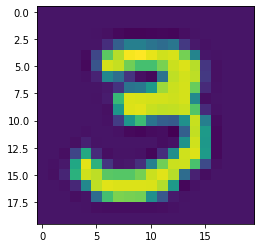


Neural Network Prediction: [3]

Paused - press enter to continue, q to exit:

Displaying Example Image



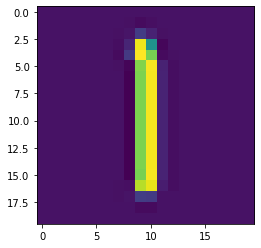


Neural Network Prediction: [1]

Paused - press enter to continue, q to exit:

Displaying Example Image



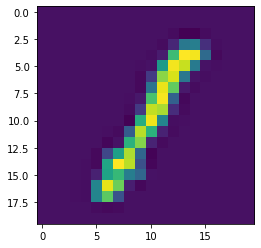


Neural Network Prediction: [1]

Paused - press enter to continue, q to exit:

Displaying Example Image



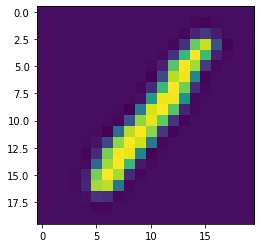


Neural Network Prediction: [1]

Paused - press enter to continue, q to exit:

Displaying Example Image



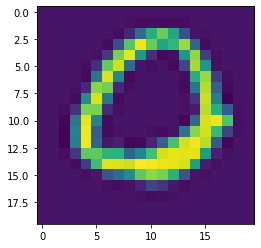


Neural Network Prediction: [0]

Paused - press enter to continue, q to exit:

Displaying Example Image



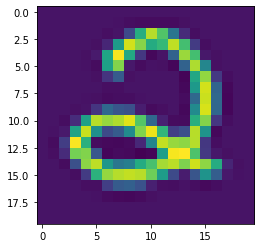


Neural Network Prediction: [2]

Paused - press enter to continue, q to exit:

Displaying Example Image



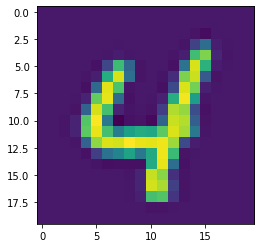


Neural Network Prediction: [4]

Paused - press enter to continue, q to exit:

Displaying Example Image



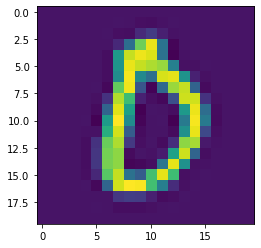


Neural Network Prediction: [0]

Paused - press enter to continue, q to exit:

Displaying Example Image



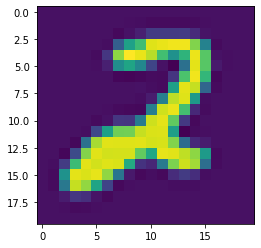


Neural Network Prediction: [2]

Paused - press enter to continue, q to exit:

Displaying Example Image



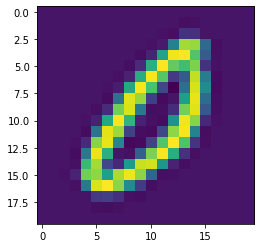


Neural Network Prediction: [0]

Paused - press enter to continue, q to exit:q


In [32]:
# Randomly permute examples
rp = np.random.randint(X.shape[0], size=n);

for i in range(10):
    # Display 
    print('\nDisplaying Example Image\n')
    display_numbers(np.array([X[rp[i], :]]))

    pred = predict(Theta1, Theta2, np.array([X[rp[i], :]]))
    print(f'\nNeural Network Prediction: {pred}\n')
    
    # Pause with quit option
    s = input('Paused - press enter to continue, q to exit:')
    if s == 'q':
        break

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez. Based on the content of the Machine Learning course offered through coursera by Prof. Andrew Ng.
</footer>